## 1: Install and Import libraries

In [1]:
#!pip install gym

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.0 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ub

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400,900))
display.start()

In [6]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
  !bash ../xvfb start
  %env DISPLAY=:1

# 2: Instantiate environment

In [7]:
env = gym.make('Acrobot-v1') # initiate gym env
env.seed(42) # set a random seed

action_space = env.action_space
state_space = env.observation_space

print(action_space)
print(state_space)

# get the shapes of the state space and action space
print(f'action space size: {action_space.n}')
print(f'state space size: {state_space.shape[0]}')

Discrete(3)
Box(-28.274333953857422, 28.274333953857422, (6,), float32)
action space size: 3
state space size: 6


# 3: Random Agent

In [8]:
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f'\nSHOWING VIDEO {mp4}')
    video = io.open(mp4,'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
def wrap_env(env,video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [9]:
env = wrap_env(env, video_callable=lambda episode_id: True)

for num_episode in range(10):
  # re-initite env for each new agent and reset score
  state = env.reset()
  score=0
  done = False

  # give an action until target reached or score is less than -500
  while not done and score >-500:
    # choose a random action
    action = random.choice([0,1,2])
    # apply the action and get the next state, the reward and a flag "done" if target reached
    next_state,reward,done,info = env.step(action)
    # visually render
    env.render()
    # update current score
    score += reward
    # update current state
    state = next_state
  
#print final score
print(f'EPISODE {num_episode + 1} - FINAL SCORE: {score}')

EPISODE 10 - FINAL SCORE: -500.0


In [10]:
# show_videos()

# 4: DQN

In [11]:
class ReplayMemory(object):
  
  def __init__(self,capacity):
    # define a queue with maxlen capacity?
    self.memory = deque(maxlen=capacity)
  
  def push(self,state,action,next_state,reward):
    # add the state, action, next_state,reward to the queue
    self.memory.append((state,action,next_state,reward))

  def sample(self,batch_size):
    # get all samples of req batch_size is larger than current memory
    # randomly select sample and return selection
    batch_size = min(batch_size, len(self)) 
    return random.sample(self.memory,batch_size)

  def __len__(self):
    # return no. of samples in memory
    return len(self.memory) 

In [12]:
class DQN(nn.Module):
  
  def __init__(self, state_space_dim, action_space_dim):
    super().__init__()

    self.linear = nn.Sequential(
        nn.Linear(state_space_dim,64),
        nn.ReLU(),
        nn.Linear(64,64*2),
        nn.ReLU(),
        nn.Linear(64*2,action_space_dim)
    )

  def forward(self,x):
    x = x.to(device)
    return self.linear(x)  

In [13]:
def choose_action_epsilon_greedy(net, state, epsilon):
  # check if epsilon is acceptable
  if epsilon > 1 or epsilon < 0:
    raise Exception('The epsilon value must be between 0 and 1')
  
  # evaluate the network current state output
  with torch.no_grad():
    net.eval()
    # convert the state to tensor
    state = torch.tensor(state, dtype=torch.float32) 
    net_out = net(state)

  # get the best action (argmax out of the network output)
  best_action = int(net_out.argmax())
  #get no. of possible actions
  action_space_dim = net_out.shape[-1]

  # select a non optimal action with prob epsilon
  # othwerwise choose the best action
  if random.random()<epsilon:
    # list of non-optimal options
    non_optimal_actions = [a for a in range (action_space_dim) 
                           if a != best_action]
    action = random.choice(non_optimal_actions)
  else:
    # select best action
    action = best_action

  return action, net_out.cpu().numpy()

In [14]:
def choose_action_softmax(net, state, temperature):
  # check if epsilon is acceptable
  if temperature < 0:
    raise Exception('The temperature value must be greater than or equal to 0')

  # if temp = 0, select best action with eps-greedy policy
  if temperature == 0:
    return choose_action_epsilon_greedy(net, state, temperature)

  # Evaluate the network output from the current state
  with torch.no_grad():
    net.eval()
    state = torch.tensor(state, dtype=torch.float32)
    net_out = net(state)

  # apply softmax with temp
  temperature = max(temperature,1e-8) # set a minimum to the temp for stability
  softmax_out = nn.functional.softmax(net_out/temperature,dim=0).cpu().numpy()

  # sample the action using softmax output as mass pdf
  all_possible_actions = np.arange(0, softmax_out.shape[-1])
  # sample random element from possible actions with probability p (from softmax)
  action = np.random.choice(all_possible_actions,p=softmax_out)

  return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

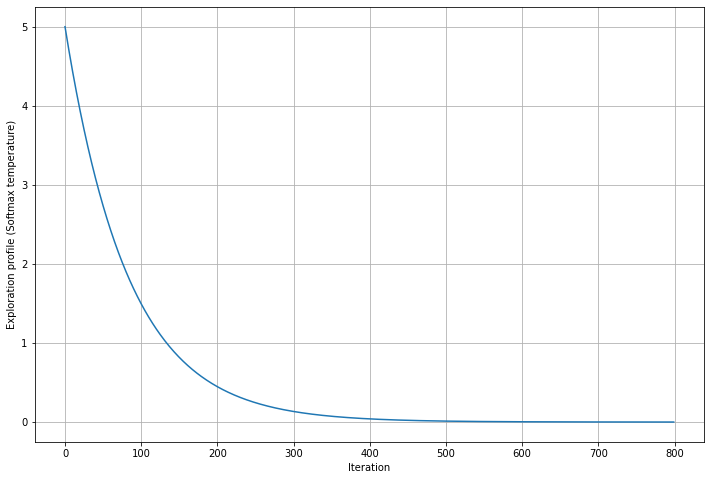

In [15]:
### Define exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # compute exp decay does not depend on the no. of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot explotation profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [16]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'STATE SPACE SIZE: {state_space_dim}')
print(f'ACTION SPACE SIZE: {action_space_dim}')

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [17]:
# set random seeds
torch.manual_seed(0)
np.random.seed(0)

### parameters
gamma = 0.99                        # gamma parameter for long term reward
replay_memory_capacity = 10_000     # replay memory capacity
# lr = 1e-2                         # optimiser learning rate
# lr = 1e-4
lr = 1e-3
target_net_update_steps = 10        # no. of episodes to wait before updating target network
batch_size = 256                    # number of samples to take from the replay memory for each update
bad_state_penalty = 0               
min_samples_for_training = 1_000    # min samples in the replay memory to enable training

In [18]:
## Initialize replay memory
replay_mem = ReplayMemory(replay_memory_capacity)

## Initialize policy network
policy_net = DQN(state_space_dim,action_space_dim).to(device)

## Initialize target network with weights of policy network
target_net = DQN(state_space_dim,action_space_dim).to(device)
## copy weights of policy to target network
target_net.load_state_dict(policy_net.state_dict())

## Initialize optimiser
# optimiser will update only the parameters of the policy network
optimiser = torch.optim.Adam(policy_net.parameters(), lr=lr)

## Initialize the loss function
loss_fn = nn.SmoothL1Loss()

In [19]:
def update_step(policy_net, target_net, replay_mem, gamma, optimiser, loss_fn, batch_size):

  # sample data from replay memory
  batch = replay_mem.sample(batch_size)
  batch_size = len(batch)

  # create tensors for each element of the batch
  states = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
  actions = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
  rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

  # compute a mask of non-final states (all the elements where the next state is not None)
  non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device)
  # next state may be None if the game has ended
  # below is to mask for states where the step is not close to an end
  non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

  # compute all the Q values (forward pass)
  policy_net.train()
  q_values = policy_net(states)
  # select proper Q value of the corresponding action taken
  state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

  # compute value function of the next states using the target network 
  # V(s_{t+1}) = max_a(Q_target(s_{t+1},a))
  with torch.no_grad():
    target_net.eval()
    q_values_target = target_net(non_final_next_states)
  next_state_max_q_values = torch.zeros(batch_size, device=device)
  next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

  # compute the expected Q values
  expected_state_action_values = rewards + (next_state_max_q_values * gamma)
  expected_state_action_values = expected_state_action_values.unsqueeze(1) # set the required tensor shape

  # compute the Huber loss
  loss = loss_fn(state_action_values, expected_state_action_values)

  # optimize the model
  optimiser.zero_grad()
  loss.backward()
 
  # apply gradient clipping (clip all gradients grreater than 2 for traininng stability)
  nn.utils.clip_grad_norm_(policy_net.parameters(),2)
  optimiser.step()

In [20]:
# initialise gym env for RL learner
env = gym.make('Acrobot-v1')
env.seed(0) 

# create output video in colab
enc = wrap_env(env,video_callable=lambda episode_id:episode_id % 100 == 0) 
# save every 100th episode

plotting_rewards = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):
  
  # reset env
  state = env.reset()
  #reset score. score is total amount of steps before target reached
  score = 0
  done = False
  
  # go until target reached
  while not done:

    # choose action on policy_net
    action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

    # apply action
    # retrieve next state, stepwise reward and flag 'done' if the game has ended
    next_state, step_reward, done, info = env.step(action)

    # update total score (+1 for each step)
    score += step_reward

    # apply penalty for bad state
    if done: # if the pole has fallen down
      reward += 0
      next_state = None

    # update replay memory
    replay_mem.push(state, action, next_state, step_reward)

    # update network
    if len(replay_mem) > min_samples_for_training: # if enough samples in replay mem, train, else, use same sample
      update_step(policy_net, target_net, replay_mem, gamma, optimiser, loss_fn, batch_size)
     
    # visually render
    env.render()

    # set current state for next iter
    state = next_state

  # update every target_net_update_steps
  if episode_num % target_net_update_steps == 0:
    target_net.load_state_dict(policy_net.state_dict()) # copy weights from policy to target net
    print('UPDATED TARGET NET')
  
  plotting_rewards.append(score)
  # print final score
  print(f'EPISODE: {episode_num + 1} - FINAL SCORE: {score} - TEMPERATURE: {tau}')

env.close()

  0%|          | 0/800 [00:00<?, ?it/s]

UPDATED TARGET NET
EPISODE: 1 - FINAL SCORE: -500.0 - TEMPERATURE: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - TEMPERATURE: 4.940008876649582
EPISODE: 3 - FINAL SCORE: -500.0 - TEMPERATURE: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - TEMPERATURE: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - TEMPERATURE: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - TEMPERATURE: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - TEMPERATURE: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - TEMPERATURE: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - TEMPERATURE: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -500.0 - TEMPERATURE: 4.485279683605809
UPDATED TARGET NET
EPISODE: 11 - FINAL SCORE: -500.0 - TEMPERATURE: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - TEMPERATURE: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - TEMPERATURE: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - TEMPERATURE: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500.0 - TEMPERATURE

In [24]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.80.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000001.mp4

SHOWING VIDEO video/openaigym.video.2.80.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.80.video000009.mp4


No handles with labels found to put in legend.


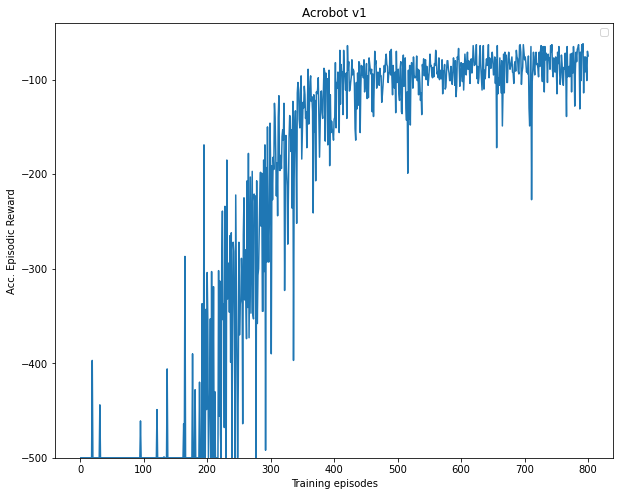

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(range(1,801),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,-40])
#plt.grid()
plt.legend()
plt.title('Acrobot v1')
plt.show()

In [23]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -84.0
EPISODE 2 - FINAL SCORE: -70.0
EPISODE 3 - FINAL SCORE: -106.0
EPISODE 4 - FINAL SCORE: -81.0
EPISODE 5 - FINAL SCORE: -78.0
EPISODE 6 - FINAL SCORE: -81.0
EPISODE 7 - FINAL SCORE: -65.0
EPISODE 8 - FINAL SCORE: -95.0
EPISODE 9 - FINAL SCORE: -94.0
EPISODE 10 - FINAL SCORE: -89.0
